CodeStates Machine Learning Project

---

# 가설

1. 초반 영상의 정보(국가, 제목, 태그, 싫어요/좋아요 비율, 조회수 대비 좋아요의 비율, description 여부)등을 바탕으로 추후 동영상의 인기 여부를 예측할 수 있을 것이다.
2. 분류 예측 모델을 활용하여 category별 광고 적합성을 파악하고, 광고 송출의 target을 좁혀 보다 효과적인 광고를 기대한다.

---

# DataSet

This dataset is a daily record of the top trending YouTube videos.

- Nation
    - US: UNITED STATES
    - CA: CANADA
    - GB: UNITED KINGDOM
    - IN: INDIA
    - FR: FRANCE
    - JP: JAPAN
    - KR: KOREA
    - DE: GERMANY
    - RU: RUSSIAN FEDERATION
    - MX: MEXICO

---

## STEP 1: Dataset

국가별로 데이터 셋을 불러온 뒤 합치고 국가코드를 기입함

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd

vedios_US = pd.read_csv('/Users/yerin/AIB/section2/project 2/USvideos.csv')
vedios_CA = pd.read_csv('/Users/yerin/AIB/section2/project 2/CAvideos.csv')
vedios_GB = pd.read_csv('/Users/yerin/AIB/section2/project 2/GBvideos.csv')
vedios_IN = pd.read_csv('/Users/yerin/AIB/section2/project 2/INvideos.csv')
vedios_FR = pd.read_csv('/Users/yerin/AIB/section2/project 2/FRvideos.csv')
vedios_JP = pd.read_csv('/Users/yerin/AIB/section2/project 2/JPvideos.csv')
vedios_KR = pd.read_csv('/Users/yerin/AIB/section2/project 2/KRvideos.csv')
vedios_DE = pd.read_csv('/Users/yerin/AIB/section2/project 2/DEvideos.csv')
vedios_RU = pd.read_csv('/Users/yerin/AIB/section2/project 2/RUvideos.csv')
vedios_MX = pd.read_csv('/Users/yerin/AIB/section2/project 2/MXvideos.csv')

In [3]:
vedios_US['Nation'] = "US"
vedios_CA['Nation'] = "CA"
vedios_GB['Nation'] = "GB"
vedios_IN['Nation'] = "IN"
vedios_FR['Nation'] = "FR"
vedios_JP['Nation'] = "JP"
vedios_KR['Nation'] = "KR"
vedios_DE['Nation'] = "DE"
vedios_RU['Nation'] = "RU"
vedios_MX['Nation'] = "MX"

In [4]:
df = pd.concat([vedios_US, vedios_CA, vedios_GB, vedios_IN, vedios_FR, vedios_JP, vedios_KR, vedios_DE, vedios_RU, vedios_MX])

In [5]:
cols = ['Nation','video_id','trending_date','title','channel_title',
 'category_id','publish_time','tags','views','likes','dislikes',
 'comment_count','thumbnail_link','comments_disabled','ratings_disabled',
 'video_error_or_removed','description']

df = df.reindex(columns=cols).reset_index(drop=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375942 entries, 0 to 375941
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Nation                  375942 non-null  object
 1   video_id                375942 non-null  object
 2   trending_date           375942 non-null  object
 3   title                   375942 non-null  object
 4   channel_title           375942 non-null  object
 5   category_id             375942 non-null  int64 
 6   publish_time            375942 non-null  object
 7   tags                    375942 non-null  object
 8   views                   375942 non-null  int64 
 9   likes                   375942 non-null  int64 
 10  dislikes                375942 non-null  int64 
 11  comment_count           375942 non-null  int64 
 12  thumbnail_link          375942 non-null  object
 13  comments_disabled       375942 non-null  bool  
 14  ratings_disabled        375942 non-n

In [7]:
df_original = df.copy()

In [8]:
df_original.publish_time.sort_values(ascending=True)

16294     2006-07-23T08:24:11.000Z
97120     2007-03-05T16:23:55.000Z
98201     2007-03-05T16:23:55.000Z
96484     2007-03-05T16:23:55.000Z
96693     2007-03-05T16:23:55.000Z
                    ...           
375851    2018-06-14T03:00:02.000Z
375782    2018-06-14T03:03:31.000Z
375809    2018-06-14T03:29:25.000Z
375820    2018-06-14T03:34:10.000Z
375800    2018-06-14T03:40:05.000Z
Name: publish_time, Length: 375942, dtype: object

In [9]:
print("likes>=10000: \t", round(len(df_original.query('likes>=10000')) / len(df_original),3))
print("views>=500000: \t", round(len(df_original.query('views>=500000')) / len(df_original),3))
print("total: \t\t", round(len(df_original.query('views>=500000 and likes>=10000')) / len(df_original),3))

likes>=10000: 	 0.331
views>=500000: 	 0.294
total: 		 0.238


---

## STEP 2: Feature Engineering

### 1. add features

1. publish_time
- date와 time으로 분리
    - date는 요일로 변환
- time을 다섯 column으로 분리
    - 총 합(초 단위), hour, minute, second
    
2. likes 대비 dislike의 비율
3. views 대비 likes의 비율
4. title의 길이
5. tag의 개수
6. description 여부(1, 0)
7. views대비 comment_count의 비율
8. comments_disabled, ratings_disabled 를 (1, 0)으로 변환

### 2. drop feature

1. 정보 누수 feature
    - comment_count
    - likes
    - dislikes
    - views

2. 분석에 필요 없는 feature
    - vedio_id
    - trending_date
    - title
    - chnnel_title
    - publish_date
    - tags
    - thumbnail_link
    - video_error_or_removed

### 3. category_id

- json파일에서 정보를 불러와 string으로 변환한 뒤, 다시 숫자로 encoding (cardinality 19)

In [10]:
df = df.drop_duplicates()

In [11]:
# 1. add features

def engineering(df):
    
    # devide publish_time as date and time
    df['publish_date'] = df.publish_time.str[:10]
    df['publish_time'] = df.publish_time.str[11:19]
    
    df['publish_hour'] = df.publish_time.str[:2].astype("int")
    df['publish_minute'] = df.publish_time.str[3:5].astype("int")
    df['publish_second'] = df.publish_time.str[6:].astype("int")
    
    df['publish_time'] = (df.publish_time.str[:2].astype("int") * 60 * 60) + (df.publish_time.str[3:5].astype("int") * 60) + (df.publish_time.str[6:].astype("int"))

    # dislikes rate
    df['dislikes/likes'] = df.dislikes / df.likes
    dislikes_null_idx = df['dislikes/likes'].loc[df['dislikes/likes'].isnull() == True].index
    dislikes_delete_idx = df['dislikes/likes'].loc[df['dislikes/likes']>1].index
    df['dislikes/likes'][dislikes_null_idx] = 0
    df['dislikes/likes'][dislikes_delete_idx] = 0
    
    # likes rate
    df['likes/view'] = df.likes / df.views
    
    # length of title
    df['title_length'] = df.title.str.len()
    
    # tag numbers

    df.tags = df.tags.str.replace("|", "#")
    df['tag_numbers'] = (df.tags.str.count("#")) + 1
    tag_none_idx = df.loc[df.tags == "[none]"].index
    df.tag_numbers[tag_none_idx] = 0
    
    # description 여부(1, 0)
    des_null_idx = df.query('description.isnull() == True').index
    df.description = 1
    df.description[des_null_idx] = 0
    
    # publish day
    df.publish_date = pd.to_datetime(df.publish_date)
    df['publish_day'] = df.publish_date.dt.day_name()
    
    # target
    target_idx = df.query('likes>=20000 and views>=500000').index
    df['target'] = 0
    df.target[target_idx] = 1
    
    # comment_count / views
    df['comment_count/views'] = df.comment_count / df.views
    
    # replace(False:0, True:1)
    df.comments_disabled = df.comments_disabled.replace({False:0, True:1})
    df.ratings_disabled = df.ratings_disabled.replace({False:0, True:1})

In [12]:
df_engineering = df.copy()
engineering(df_engineering)

In [13]:
# 2. drop features

df_engineering = df_engineering.drop(['video_id', 'trending_date', 'title', 'channel_title', 'comment_count',
                  'publish_date', 'tags', 'thumbnail_link', 'likes', 'views', 'dislikes', 'video_error_or_removed'], axis=1)

In [14]:
cols = ['Nation', 'category_id', 'publish_day', 'publish_time', 'publish_hour',
 'publish_minute', 'publish_second','comment_count/views',
 'comments_disabled','ratings_disabled','description','dislikes/likes','likes/view',
 'title_length','tag_numbers','target']

In [15]:
df_engineering = df_engineering.reindex(columns=cols)

In [16]:
# 3. convert category_id

def category(file):
    
    import json
    
    df_engineering.category_id = df_engineering.category_id.astype("str")
    nation = file[:2]
    
    with open(file, 'r') as f:
        categories = json.load(f)
        
    dic = {}
    
    for category_id in categories['items']:
        dic[category_id['id']] = category_id['snippet']['title']
    
    idx = df_engineering.loc[df.Nation == nation].category_id.index
        
    df_engineering.category_id[idx] = df_engineering.category_id[idx].replace(dic)

In [17]:
category('CA_category_id.json')
category('US_category_id.json')
category('FR_category_id.json')
category('GB_category_id.json')
category('JP_category_id.json')
category('KR_category_id.json')
category('IN_category_id.json')
category('DE_category_id.json')
category('MX_category_id.json')
category('RU_category_id.json')

In [18]:
df_engineering

,Nation,category_id,publish_day,publish_time,publish_hour,publish_minute,publish_second,comment_count/views,comments_disabled,ratings_disabled,description,dislikes/likes,likes/view,title_length,tag_numbers,target
0,US,People & Blogs,Monday,61981,17,13,1,0.021318,0,0,1,0.051558,0.076869,34,1,1
1,US,Entertainment,Monday,27000,7,30,0,0.005252,0,0,1,0.063240,0.040179,62,4,1
2,US,Comedy,Sunday,68724,19,5,24,0.002563,0,0,1,0.036560,0.045758,53,23,1
3,US,Entertainment,Monday,39604,11,0,4,0.006253,0,0,1,0.065474,0.029641,32,27,0
4,US,Entertainment,Sunday,64901,18,1,41,0.008359,0,0,1,0.015041,0.063097,24,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375937,MX,Sports,Wednesday,47516,13,11,56,0.005858,0,0,1,0.008333,0.100502,53,32,1
375938,MX,News & Politics,Wednesday,4508,1,15,8,0.004035,0,0,1,0.016301,0.029242,51,7,0
375939,MX,Entertainment,Wednesday,54533,15,8,53,0.006398,0,0,1,0.011152,0.038246,49,11,0
375940,MX,People & Blogs,Wednesday,8553,2,22,33,0.000131,0,0,0,0.117021,0.004105,42,0,0


In [19]:
df_engineering.category_id.nunique()

19

In [20]:
df_engineering.isnull().sum()

Nation                 0
category_id            0
publish_day            0
publish_time           0
publish_hour           0
publish_minute         0
publish_second         0
comment_count/views    0
comments_disabled      0
ratings_disabled       0
description            0
dislikes/likes         0
likes/view             0
title_length           0
tag_numbers            0
target                 0
dtype: int64

In [21]:
df_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363372 entries, 0 to 375941
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Nation               363372 non-null  object 
 1   category_id          363372 non-null  object 
 2   publish_day          363372 non-null  object 
 3   publish_time         363372 non-null  int64  
 4   publish_hour         363372 non-null  int64  
 5   publish_minute       363372 non-null  int64  
 6   publish_second       363372 non-null  int64  
 7   comment_count/views  363372 non-null  float64
 8   comments_disabled    363372 non-null  int64  
 9   ratings_disabled     363372 non-null  int64  
 10  description          363372 non-null  int64  
 11  dislikes/likes       363372 non-null  float64
 12  likes/view           363372 non-null  float64
 13  title_length         363372 non-null  int64  
 14  tag_numbers          363372 non-null  int64  
 15  target           

---

## STEP 3: Modeling

1. label과 feature로 나누기 전 shuffle 해준다.
2. train, validation, test set으로 나눈다.
3. modeling 및 튜닝
4. feature importance 확인

In [22]:
df_engineering_copy = df_engineering.copy()

In [23]:
import sklearn

df_shuffled = sklearn.utils.shuffle(df_engineering, random_state=2).reset_index(drop=True)
df_shuffled

,Nation,category_id,publish_day,publish_time,publish_hour,publish_minute,publish_second,comment_count/views,comments_disabled,ratings_disabled,description,dislikes/likes,likes/view,title_length,tag_numbers,target
0,CA,People & Blogs,Thursday,68653,19,4,13,0.005937,0,0,1,0.030282,0.052438,38,19,0
1,US,People & Blogs,Thursday,84040,23,20,40,0.003075,0,0,1,0.080040,0.050419,40,9,0
2,DE,People & Blogs,Friday,76209,21,10,9,0.001737,0,0,1,0.099724,0.010875,26,17,0
3,IN,Entertainment,Wednesday,31039,8,37,19,0.002110,0,0,1,0.038841,0.040768,77,31,1
4,FR,Gaming,Monday,19801,5,30,1,0.002910,0,0,0,0.032710,0.045784,23,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363367,GB,Howto & Style,Tuesday,84776,23,32,56,0.005136,0,0,1,0.035502,0.063424,44,24,1
363368,GB,Pets & Animals,Tuesday,3,0,0,3,0.002938,0,0,1,0.018868,0.029197,47,33,0
363369,JP,Entertainment,Monday,34200,9,30,0,0.002949,0,0,1,0.048304,0.021253,25,93,0
363370,GB,Comedy,Monday,70171,19,29,31,0.001166,0,0,1,0.010609,0.056104,29,14,1


In [24]:
corr = df_shuffled.corr()
target_corr = round(abs(df_shuffled.corr().iloc[12][:-1]),2)
print(target_corr)

publish_time           0.03
publish_hour           0.04
publish_minute         0.10
publish_second         0.06
comment_count/views    0.02
comments_disabled      0.04
ratings_disabled       0.07
description            0.10
dislikes/likes         0.16
likes/view             0.12
title_length           0.11
tag_numbers            0.09
Name: target, dtype: float64


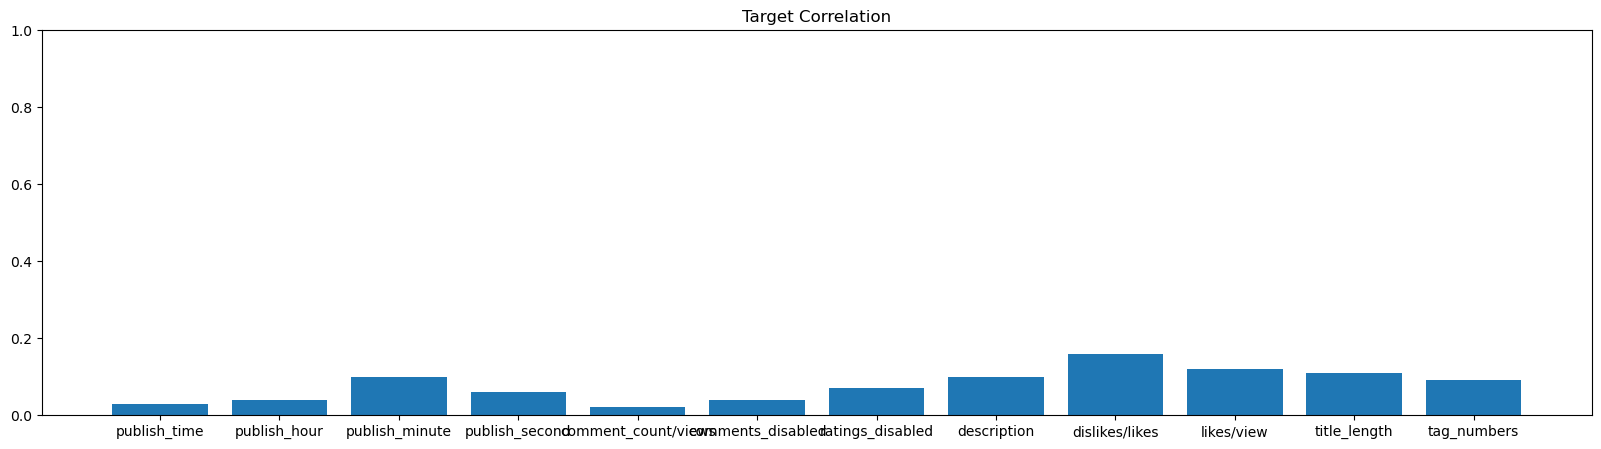

In [25]:
import matplotlib.pyplot as plt

# 대략 0.1 사이에서 머문다.

plt.figure(figsize=(20,5))
plt.bar(corr.columns[:-1], target_corr)
plt.title("Target Correlation")
plt.ylim(0, 1);

In [26]:
# target의 비율은 약 8:2

df_shuffled.target.value_counts(normalize=True)

0    0.799148
1    0.200852
Name: target, dtype: float64

In [27]:
# 국가별로 target의 비율이 어느정도인지 확인
# 국가별로 편향이 발생할 수 있음(국가별로 다른 기준을 부여해야하는지?)

df_shuffled.groupby('Nation')['target'].mean().sort_values(ascending=False)

Nation
GB    0.521719
US    0.439427
CA    0.278222
IN    0.169573
DE    0.135798
FR    0.098492
MX    0.085293
RU    0.073428
JP    0.038731
KR    0.038634
Name: target, dtype: float64

In [28]:
# X, y split

from sklearn.model_selection import train_test_split

target = 'target'

X = df_shuffled.drop([target], axis=1)
y = df_shuffled[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, stratify = y_train, random_state=42)

In [29]:
X_train.shape, y_train.shape

((178052, 15), (178052,))

In [30]:
X_val.shape, y_val.shape

((76308, 15), (76308,))

In [31]:
X_test.shape, y_test.shape

((109012, 15), (109012,))

In [32]:
y_train.value_counts(normalize=True)

0    0.799149
1    0.200851
Name: target, dtype: float64

In [33]:
y_val.value_counts(normalize=True)

0    0.799143
1    0.200857
Name: target, dtype: float64

In [34]:
y_test.value_counts(normalize=True)

0    0.799151
1    0.200849
Name: target, dtype: float64

In [35]:
# base model

from sklearn.metrics import accuracy_score

base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_acc = accuracy_score(y_train, baseline)
print(f'기준모델의 정확도: {baseline_acc.round(3)}')

기준모델의 정확도: 0.799


In [36]:
# pipeline

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from xgboost import XGBClassifier
from scipy.stats.distributions import uniform
from sklearn.model_selection import RandomizedSearchCV


pipe_XGB = make_pipeline(OrdinalEncoder(),
                        XGBClassifier( objective = "binary:logistic",
                                        eval_metric = "error",
                                        n_estimators = 100,
                                        random_state = 2,
                                        n_jobs = -1,
                                        learning_rate = 0.2,
                                        min_child_weight = 8,
                                        max_depth = 20,
                                        colsample_bytree = 0.55,
                                        gamma = 1,
                                        subsample = 0.5))

params = {"xgbclassifier__max_depth": [17, 18, 19, 20],
          "xgbclassifier__colsample_bytree": uniform(loc=0.4, scale=0.2),
         "xgbclassifier__min_child_weight": [6, 7, 8, 9, 10]
         }

clf = RandomizedSearchCV(pipe_XGB,
                        param_distributions=params,
                        scoring="f1",
                        n_iter=5,
                        cv=3,
                        verbose=3,
                        random_state=42)

In [37]:
pipe_XGB.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Nation', 'category_id', 'publish_day'],
                                mapping=[{'col': 'Nation',
                                          'data_type': dtype('O'),
                                          'mapping': KR      1
GB      2
RU      3
MX      4
CA      5
DE      6
US      7
IN      8
FR      9
JP     10
NaN    -2
dtype: int64},
                                         {'col': 'category_id',
                                          'data_type': dtype('O'),
                                          'mapping': News & Politics           1
Music                     2
Entertainment             3
Film & Animation          4
Sports                    5
Comedy                    6
Howto & Style             7
People & Blogs            8
Educatio...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                  

In [38]:
#### train set의 report (threshold X)

from sklearn.metrics import classification_report

y_train_pred = pipe_XGB.predict(X_train)

print("train Set의 평가지표")
print(classification_report(y_train, y_train_pred))

train Set의 평가지표
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    142290
           1       0.98      0.91      0.94     35762

    accuracy                           0.98    178052
   macro avg       0.98      0.95      0.96    178052
weighted avg       0.98      0.98      0.98    178052



In [39]:
# print(clf.best_params_)
# print(clf.best_score_)

In [40]:
# validation set의 report (threshold X)

y_val_pred = pipe_XGB.predict(X_val)

print("Validation Set의 평가지표")
print(classification_report(y_val, y_val_pred))

Validation Set의 평가지표
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     60981
           1       0.89      0.78      0.83     15327

    accuracy                           0.94     76308
   macro avg       0.92      0.88      0.90     76308
weighted avg       0.94      0.94      0.93     76308



In [41]:
y_val.value_counts()

0    60981
1    15327
Name: target, dtype: int64

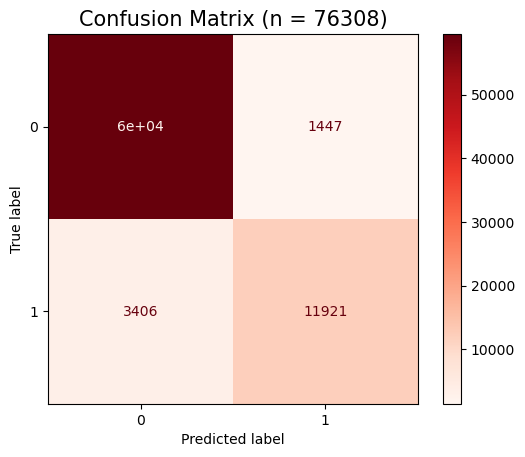

In [42]:
# confusion matrix

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(pipe_XGB, X_val, y_val, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_val)})", fontsize=15);

In [43]:
import eli5
from eli5.sklearn import PermutationImportance

def get_permutation_importance(X, y, model):

    permuter = PermutationImportance(model, scoring = "roc_auc", n_iter=5, random_state=42)
    permuter.fit(X, y)

    return permuter

In [44]:
# test set의 report (threshold X)

print("test report")
y_test_pred = pipe_XGB.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(y_test_pred.sum())

test report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     87117
           1       0.90      0.78      0.84     21895

    accuracy                           0.94    109012
   macro avg       0.92      0.88      0.90    109012
weighted avg       0.94      0.94      0.94    109012

19081


In [45]:
y_test.value_counts()

0    87117
1    21895
Name: target, dtype: int64

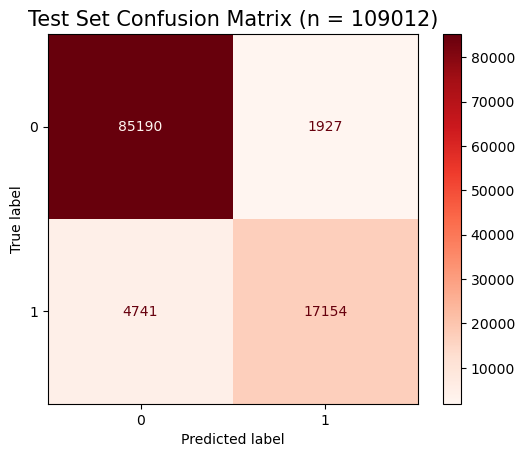

In [46]:
plot_confusion_matrix(pipe_XGB, X_test, y_test, cmap=plt.cm.Reds)
plt.title(f"Test Set Confusion Matrix (n = {len(y_test)})", fontsize=15);

In [47]:
# permutation importance

preprocess_pipeline = pipe_XGB[0]
model = pipe_XGB[1]
encoder = OrdinalEncoder()

X_test_preprocessed = preprocess_pipeline.fit_transform(X_test)
X_test_encoded = encoder.fit_transform(X_test)

permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test_encoded.columns.tolist())
print("Important Features:")
p_i_test = sorted(
    list(zip(X_test_encoded.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i_test)

Important Features:
[('likes/view', 0.19644792602162947), ('comment_count/views', 0.05696149075903012), ('publish_time', 0.05454729132280174), ('tag_numbers', 0.04275303316174835), ('title_length', 0.041531897963377175), ('category_id', 0.0410297255378431), ('dislikes/likes', 0.040310848587438254), ('publish_second', 0.02642786231501417), ('publish_minute', 0.025946780712882988), ('publish_hour', 0.005355138427952544), ('publish_day', 0.0034276125780275057), ('description', 0.003009641290464815), ('comments_disabled', 0.00043520869948581175), ('ratings_disabled', 8.028402810733581e-05), ('Nation', -3.1155482689282366e-05)]


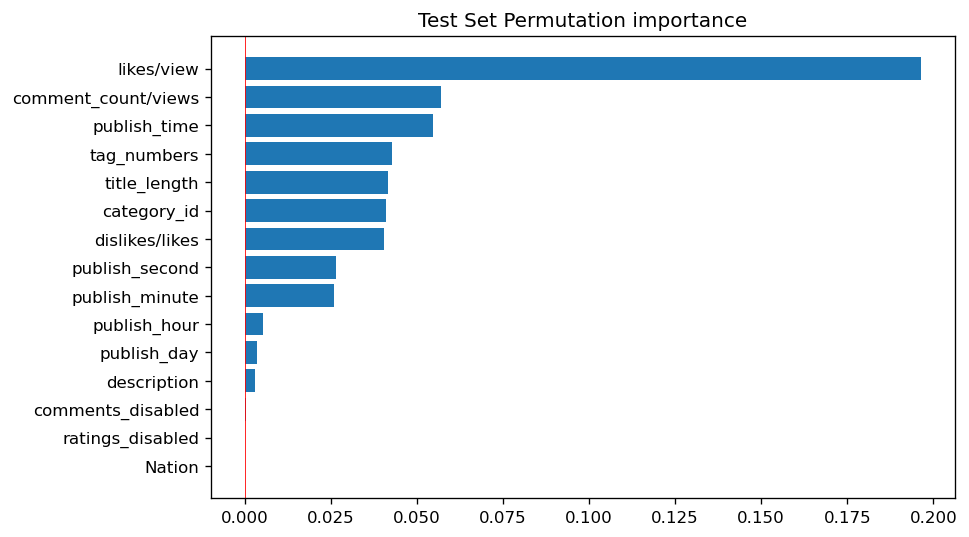

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=120)
plt.title("Test Set Permutation importance")
plt.barh(*list(zip(*p_i_test[::-1])))
plt.axvline(0.0, color="red", linewidth=0.5);

## Interpret Feature

### model은 x축 지점에서 target이 1일 확률 y축으로 표시합니다.

(-0.1, 0.5)

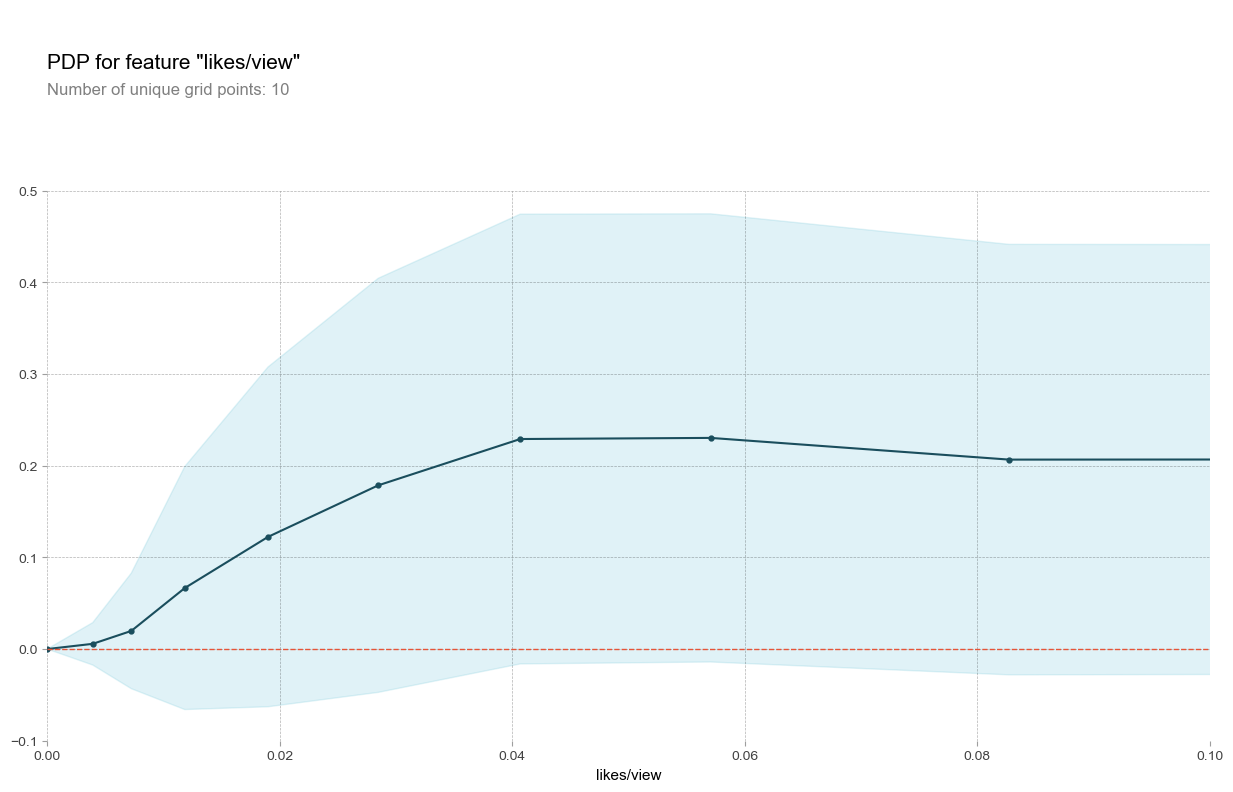

In [49]:
# 조회수 대비 좋아요의 수가 4%를 초과하면 target일 확률이 40%

from pdpbox import pdp, get_dataset

pdp_likes = pdp.pdp_isolate(model=pipe_XGB,
                          dataset=df_shuffled,
                          model_features=X_test_encoded.columns,
                          feature='likes/view')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_likes, feature_name='likes/view')
plt.xlim((0.0, 0.1))
plt.ylim((-0.1,0.5))

(-0.1, 0.2)

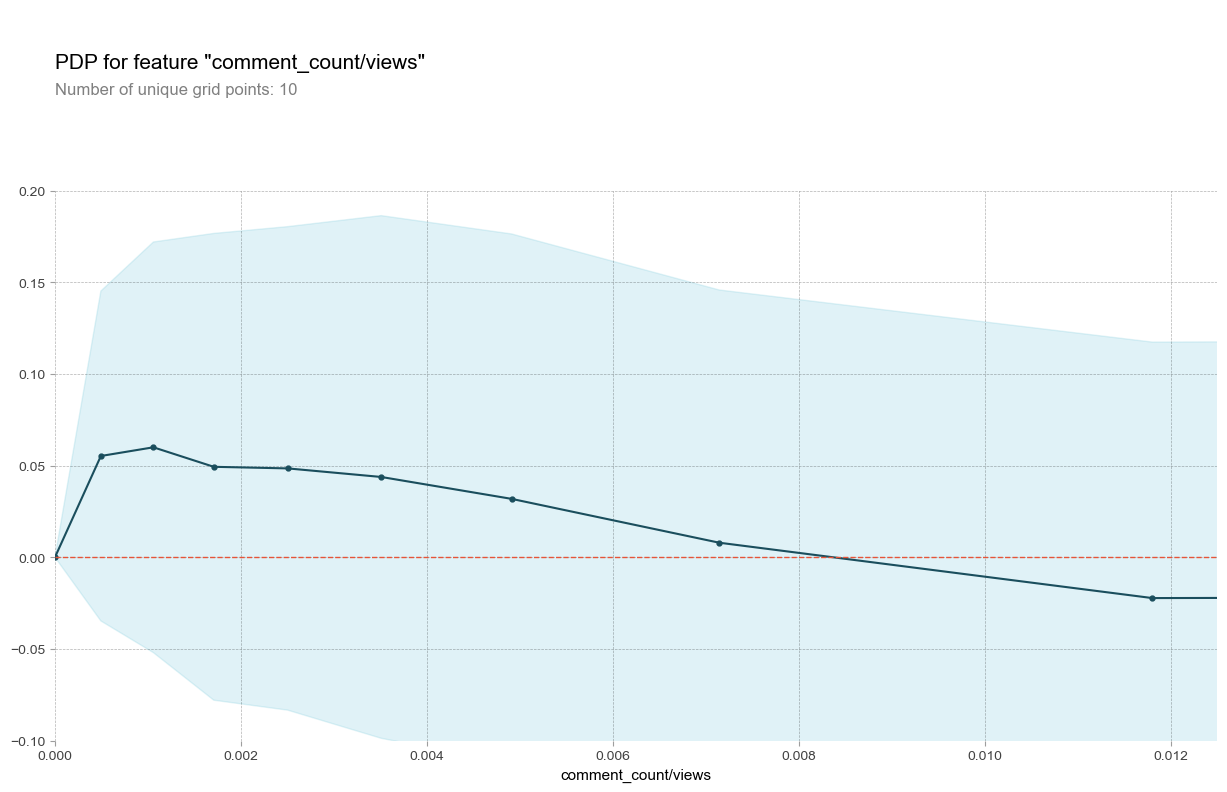

In [50]:
from pdpbox import pdp, get_dataset

pdp_comment = pdp.pdp_isolate(model=pipe_XGB,
                          dataset=df_shuffled,
                          model_features=X_test_encoded.columns,
                          feature='comment_count/views')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_comment, feature_name='comment_count/views')
plt.xlim((0.0, 0.0125))
plt.ylim((-0.1,0.2))

(-0.1, 0.2)

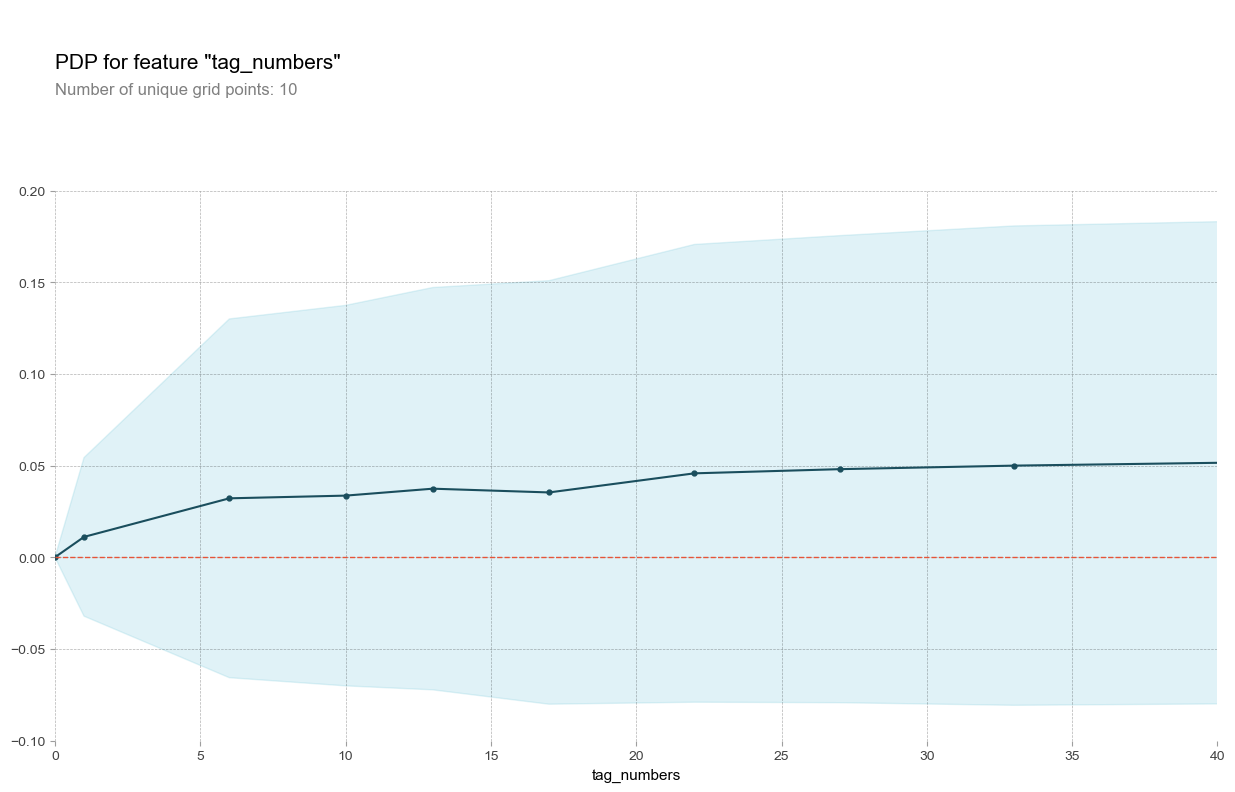

In [51]:
from pdpbox import pdp, get_dataset

pdp_tag = pdp.pdp_isolate(model=pipe_XGB,
                          dataset=df_shuffled,
                          model_features=X_test_encoded.columns,
                          feature='tag_numbers')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_tag, feature_name='tag_numbers')
plt.xlim((0, 40))
plt.ylim((-0.1,0.2))

(-0.1, 0.2)

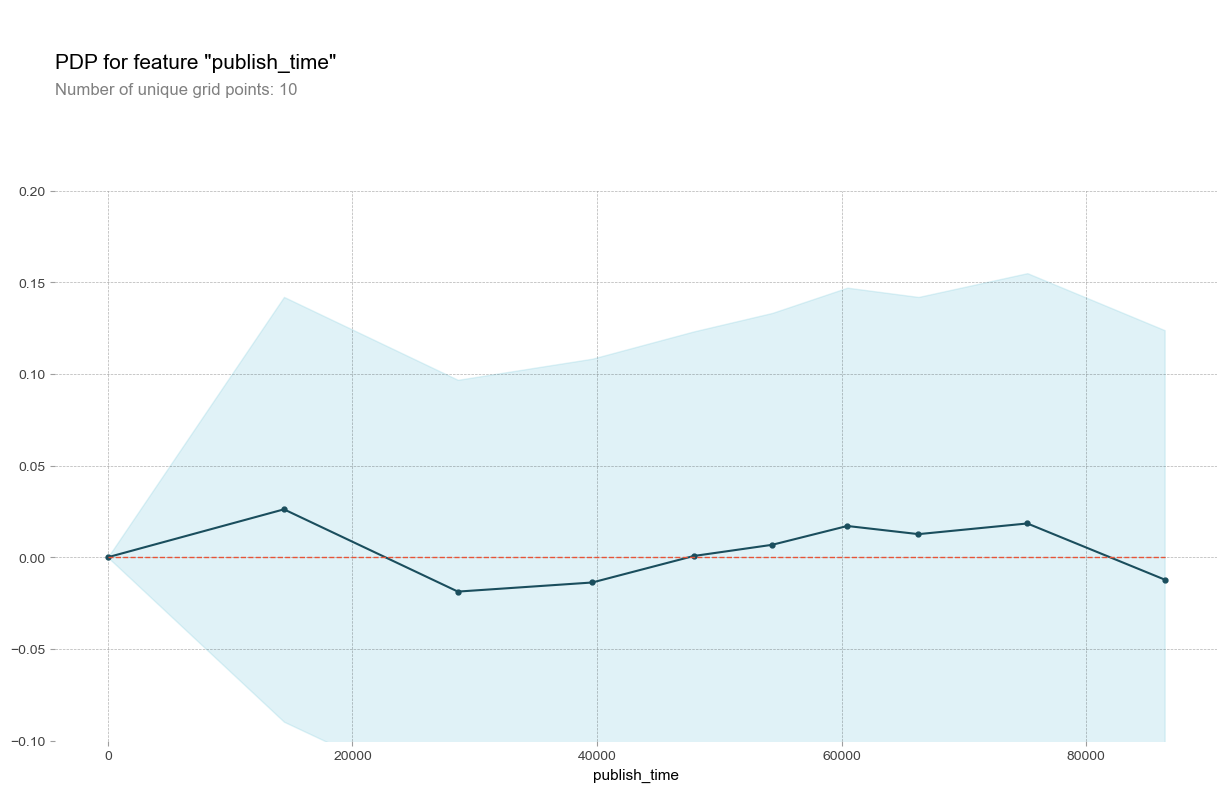

In [52]:
pdp_publish = pdp.pdp_isolate(model=pipe_XGB,
                          dataset=df_shuffled,
                          model_features=X_test_encoded.columns,
                          feature='publish_time')

fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_publish, feature_name='publish_time')

plt.ylim((-0.1,0.2))

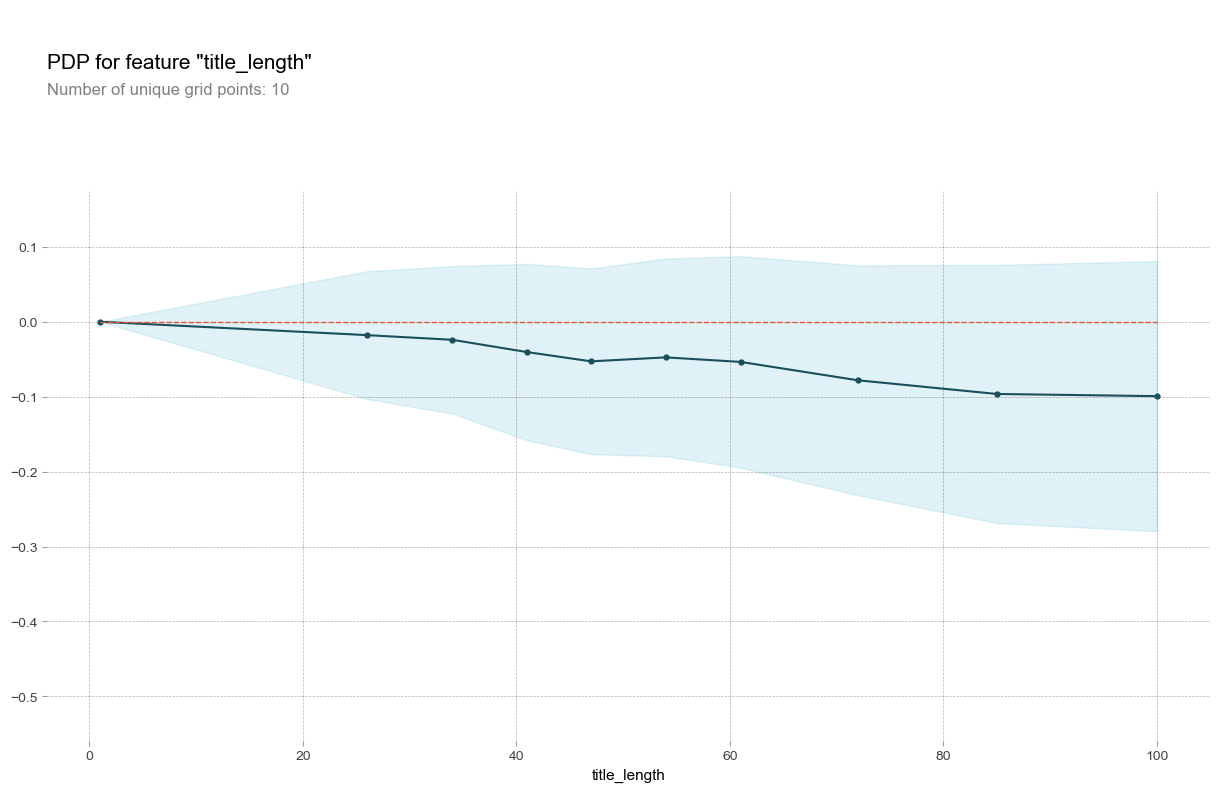

In [53]:
pdp_title = pdp.pdp_isolate(model=pipe_XGB,
                          dataset=df_shuffled,
                          model_features=X_test_encoded.columns,
                          feature='title_length')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_title, feature_name='title_length')

(0.0, 0.3)

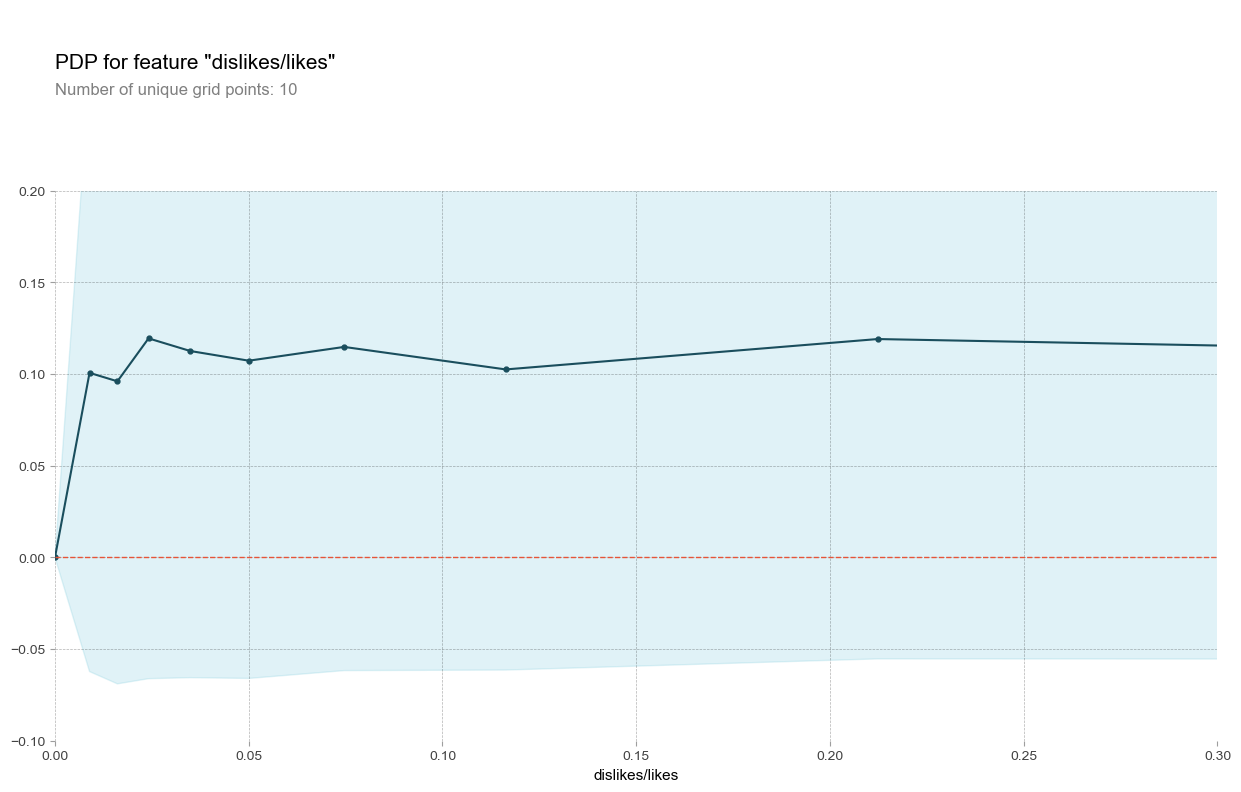

In [54]:
pdp_dislikes = pdp.pdp_isolate(model=pipe_XGB,
                          dataset=df_shuffled,
                          model_features=X_test_encoded.columns,
                          feature='dislikes/likes')

fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_dislikes, feature_name='dislikes/likes')

plt.ylim((-0.1,0.2))
plt.xlim((0, 0.3))

In [56]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

target_features = ["dislikes/likes", "likes/view"]

interaction = pdp_interact(
    model=pipe_XGB,
    dataset=X_test_encoded,
    model_features=X_test_encoded.columns,
    features=target_features,
)

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <Axes: >,
  'pdp_inter_ax': <Axes: xlabel='dislikes/likes', ylabel='likes/view'>})

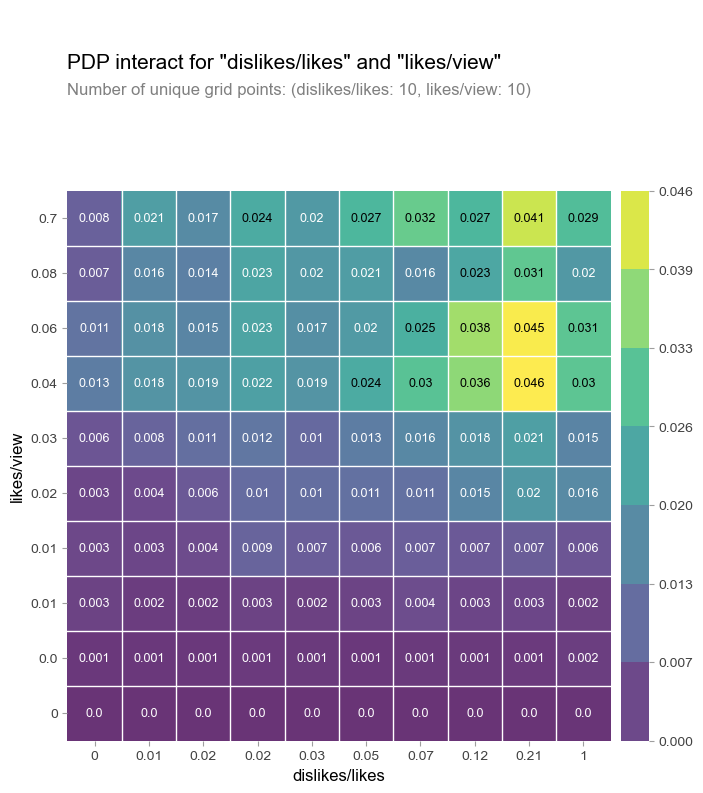

In [57]:
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)